<a href="https://colab.research.google.com/github/ofri09bs/Jarvis-Discord-bot/blob/main/Malware_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports and mount the drive

In [4]:
import os
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading all the data

In [5]:
benign_path = '/content/drive/MyDrive/AntiMalware Project/data/benign'
malicious_path = '/content/drive/MyDrive/AntiMalware Project/data/malicious'

benign_files = os.listdir(benign_path)
malicious_files = os.listdir(malicious_path)

benign_data = []
for file in benign_files:
  try:
    with open(os.path.join(benign_path, file), 'r', encoding='latin-1', errors='ignore') as f:
      data = f.read()
      benign_data.append({'data': data, 'label': 'benign'})
  except Exception as e:
    print(f"Error reading file {file}: {e}")

malicious_data = []
for file in malicious_files:
  try:
    with open(os.path.join(malicious_path, file), 'r', encoding='latin-1', errors='ignore') as f:
      data = f.read()
      malicious_data.append({'data': data, 'label': 'malicious'})
  except Exception as e:
    print(f"Error reading file {file}: {e}")

benign_df = pd.DataFrame(benign_data)
malicious_df = pd.DataFrame(malicious_data)

# Concatenate the two dataframes
combined_df = pd.concat([benign_df, malicious_df], ignore_index=True)

display(combined_df.head())

,data,label
0,#!/bin/sh\n\n##\n# Script for calling ant with...,benign
1,::\n: Script for manually building the javadoc...,benign
2,set ANT_CALL=help\nset BUILD_FILE=..\build.xml...,benign
3,#!/bin/sh\n\n##\n# Script for calling ant with...,benign
4,set ANT_CALL=build\nset BUILD_FILE=..\build.xm...,benign


Researching and studying the data

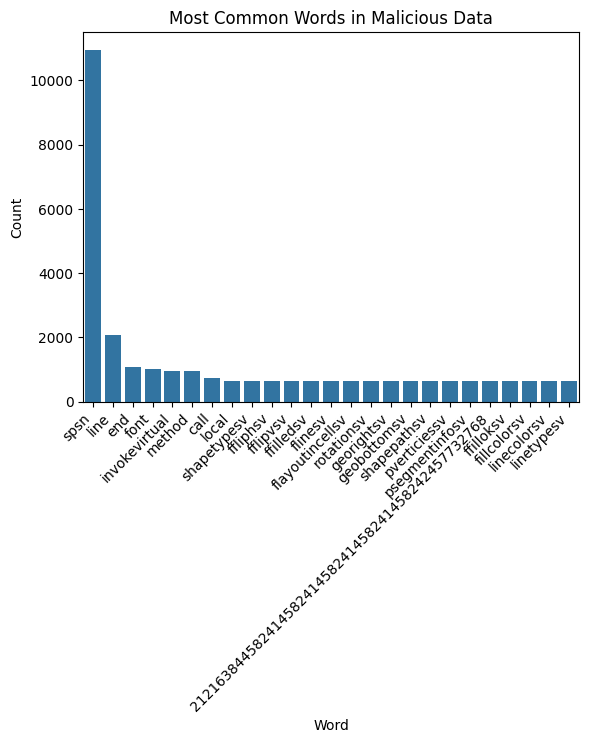

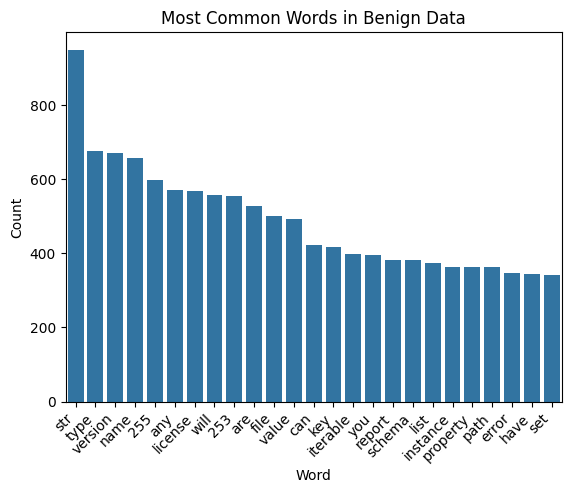

In [6]:
def count_words(df, column='data', top_n=25):
    all_data = ' '.join(df[column].astype(str)).lower()
    all_data = re.sub(r'[^\w\s]', '', all_data)

    ignore_words = [
        # general words
        'the', 'and', 'or', 'to', 'in', 'not', 'a', 'an', 'of', 'is', 'it', 'this', 'that','bin','bash'
        # python saved words
        'if', 'else', 'elif', 'while', 'for', 'def', 'return', 'import', 'from', 'as', 'with',
        'try', 'except', 'finally', 'class', 'self', 'lambda', 'pass', 'break', 'continue',
        'global', 'nonlocal', 'yield', 'assert', 'raise', 'del', 'print', 'input',
        # C saved words
        'int', 'char', 'float', 'double', 'long', 'short', 'void', 'struct', 'typedef',
        'const', 'static', 'extern', 'auto', 'register', 'unsigned', 'signed', 'enum',
        'sizeof', 'include', 'define', 'main', 'printf', 'scanf', 'return',
        # java saved words
        'public', 'private', 'protected', 'class', 'static', 'final', 'void', 'new',
        'package', 'import', 'extends', 'implements', 'this', 'super', 'interface',
        'throws', 'try', 'catch', 'finally', 'throw', 'return', 'instanceof','string',
        # numbers and logical words
        'true', 'false', 'null', 'none', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        # file names
        'h', 'c', 'py', 'java', 'cpp', 'hpp', 'txt'
    ]
    words = []
    for word in all_data.split():
        if word not in ignore_words and len(word)>2:
            words.append(word)

    word_counts = Counter(words)
    df_counts = pd.DataFrame(word_counts.most_common(top_n), columns=['Word', 'Count'])
    return df_counts


malicious_words = count_words(malicious_df)
benign_words = count_words(benign_df)
sns.barplot(x='Word', y='Count', data=malicious_words).set_title('Most Common Words in Malicious Data')
plt.xticks(rotation=45, ha='right')
plt.show()

sns.barplot(x='Word', y='Count', data=benign_words).set_title('Most Common Words in Benign Data')
plt.xticks(rotation=45, ha='right')
plt.show()

features engineering:

In [10]:
#Function to calculate entropy (mess)
def calc_entropy(data):
  if not data:
    return 0
  counter = Counter(data)
  length = len(data)
  entropy = 0
  for count in counter.values():
      p = count / length
      entropy -= p * math.log2(p)
  return entropy

#Function the extreact all the features
def extract_features(file_path):

  features = {}
  try:
    with open(file_path, 'rb') as f:
      byte_data = f.read()

    try:
      text_data = byte_data.decode('utf-8')
    except UnicodeDecodeError:
      text_data = byte_data.decode('latin-1', errors='replace')

    features['file_size'] = len(byte_data)
    features['entropy'] = calc_entropy(byte_data)

    lines = text_data.splitlines()
    if lines:
      features['num_lines'] = len(lines)
      features['avg_line_length'] = sum(len(line) for line in lines) / len(lines)
      features['max_line_length'] = max(len(line) for line in lines)
    else:
      features['num_lines'] = 0
      features['avg_line_length'] = 0
      features['max_line_length'] = 0


    malicious_patterns = [
    # network
    r"socket", r"connect", r"http\.", r"https\.", r"Invoke-WebRequest", r"wget", r"curl", r"paramiko", r"ftplib", r"send", r"recv",
    # persistence
    r"RegSetValueEx", r"CreateService", r"schtasks", r"crontab", r"Startup", r"Register-ScheduledTask", r"System\.setProperty\('java.system.class.loader'\)",
    # injection
    r"WriteProcessMemory", r"CreateRemoteThread", r"VirtualAllocEx", r"NtUnmapViewOfSection",
    # eval/exec
    r"\beval\b", r"\bexec\b", r"IEX", r"Runtime\.getRuntime\(\)\.exec", r"child_process\.exec", r"System\.exec",
    # crypto
    r"\bAES\b", r"\bRSA\b", r"CryptEncrypt", r"javax\.crypto", r"pycrypto", r"cryptography", r"CryptGenKey", r"BCryptEncrypt",
    # download/execute
    r"URLDownloadToFile", r"Invoke-WebRequest", r"DownloadFile", r"requests\.get", r"urllib\.request",
    # privilege escalation
    r"SeDebugPrivilege", r"AdjustTokenPrivileges", r"setuid", r"sudo", r"runas", r"CreateProcessAsUser",
    # keylogger
    r"SetWindowsHookEx", r"GetAsyncKeyState", r"pynput", r"keylogger", r"GetClipboardData",
    # ransomware
    r"HOW_TO_DECRYPT", r"HOWTO_DECRYPT", r"ransom", r"readme", r"bitcoin", r"tor", r"vssadmin", r"DeleteShadowCopy", r"DeleteShadowCopies",
    # file operations
    r"fopen", r"fwrite", r"WriteFile", r"CopyFile", r"FileCopy", r"FileOutputStream", r"MoveFile", r"DeleteFile", r"ftruncate", r"rename",
    # shell exec
    r"os\.system", r"subprocess", r"Shell", r"Runtime\.getRuntime", r"Process\.Start", r"CreateProcess",
    # SQL injection
    r"xp_cmdshell", r"SELECT\s+INTO\s+OUTFILE", r"LOAD_FILE", r"sp_executesql", r"EXEC\s+",
    # DDoS
    r"flood", r"synflood", r"udp_flood", r"http_flood", r"scapy", r"hping", r"botnet",
    # rootkit
    r"DriverEntry", r"insmod", r"IAT", r"NtQueryDirectoryFile", r"rootkit", r"hide_process", r"module_init",
    # VBA macros
    r"CreateObject\(\"Wscript\.Shell\"\)", r"Open\s+.*\s+For\s+Binary", r"FileCopy", r"Kill",
    # bash/shell
    r"nc\b", r"ncat\b", r"ssh\b", r"scp\b", r"chmod\s+\+x", r"rm\s+-rf", r"cron\b", r"crontab\b"
    ]
    df_words= malicious_words['Word'].tolist()
    all_words = df_words + malicious_patterns
    pattern_combined = r'|'.join(re.escape(w) for w in all_words)

    weird_chars = len(re.findall(r'[^a-zA-Z0-9\s]', text_data,re.IGNORECASE))
    features['weird_char_ratio'] = weird_chars / len(text_data) if len(text_data) > 0 else 0
    features['malicious_words'] = len(re.findall(pattern_combined, text_data, flags=re.IGNORECASE))

    return features

  except Exception as e:
    print(f"Error extracting features from {file_path}: {e}")
    return None # Return None in case of error

building the final data table

In [11]:
data_list = []

for filename in os.listdir(benign_path):
    file_path = os.path.join(benign_path, filename)
    if os.path.isfile(file_path):
      features = extract_features(file_path)
      if features:
        features['label'] = 'benign'
        features['filename'] = filename
        data_list.append(features)

for filename in os.listdir(malicious_path):
    file_path = os.path.join(malicious_path, filename)
    if os.path.isfile(file_path):
      features = extract_features(file_path)
      if features:
        features['label'] = 'malicious'
        features['filename'] = filename
        data_list.append(features)


df = pd.DataFrame(data_list)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

training and building the model (Random Forest)

582

--- Model Performance Report ---
Accuracy: 87.18%
F1 Score: 84.21%
Recall: 93.02%
Precision: 76.92%

Detailed Report:
              precision    recall  f1-score   support

      benign       0.95      0.84      0.89        74
   malicious       0.77      0.93      0.84        43

    accuracy                           0.87       117
   macro avg       0.86      0.88      0.87       117
weighted avg       0.89      0.87      0.87       117


Confusion Matrix:


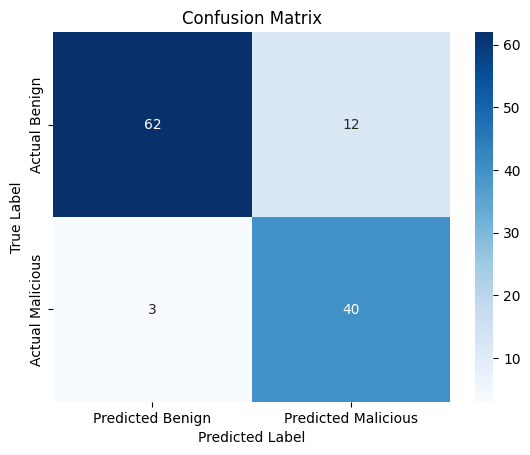

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score,recall_score,precision_score

X = df.drop(['label','filename'],axis = 1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n--- Model Performance Report ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"F1 Score: {f1_score(y_test, y_pred, pos_label='malicious'):.2%}")
print(f"Recall: {recall_score(y_test, y_pred, pos_label='malicious'):.2%}")
print(f"Precision: {precision_score(y_test, y_pred, pos_label='malicious'):.2%}")

print("\nDetailed Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Benign', 'Predicted Malicious'],
            yticklabels=['Actual Benign', 'Actual Malicious'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

top important features

/tmp/ipython-input-3841200568.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis')


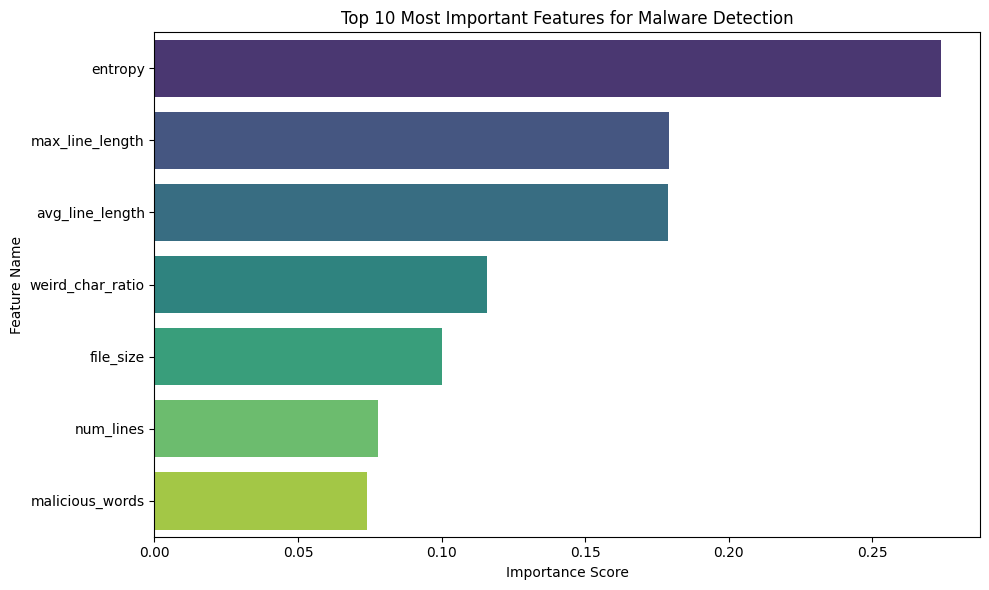

Top 10 Features:
            feature  importance
1           entropy    0.273819
4   max_line_length    0.179131
3   avg_line_length    0.178918
5  weird_char_ratio    0.115955
0         file_size    0.100171
2         num_lines    0.077998
6   malicious_words    0.074008


In [14]:
importances = model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Most Important Features for Malware Detection')
plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.tight_layout()
plt.show()

print("Top 10 Features:")
print(feature_importance_df.head(10))

In [16]:
import joblib

joblib.dump(model, "/content/drive/MyDrive/malware project/antiMal.pkl")

['/content/drive/MyDrive/malware project/antiMal.pkl']